In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
from pandas.tools.plotting import scatter_matrix

if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### read the csv through pandas

In [2]:
nrg = pd.read_csv(os.getenv("PUIDATA")+"/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
#bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/mn_mappluto_16v1/MNMapPLUTO.shp")

In [3]:
nrg.columns

Index([u'Record Number', u'NYC Borough, Block, and Lot (BBL)',
       u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')

In [239]:
#nrg.head()

### download the zipfile (or any dataset online)

In [3]:
!curl -O "https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.6M  100 11.6M    0     0  28.7M      0 --:--:-- --:--:-- --:--:-- 47.4M


### unzip the zipfile and store it in PUIDATA

In [4]:
import zipfile

zip = zipfile.ZipFile('mn_mappluto_16v1.zip','r')
zip.extractall(os.getenv('PUIDATA') + '/mn_mappluto_16v1')

bsize = gp.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/mn_mappluto_16v1/MNMapPLUTO.shp')

In [20]:
bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

### clean up the data and make a raw plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71821f33d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f71b0761a90>]], dtype=object)

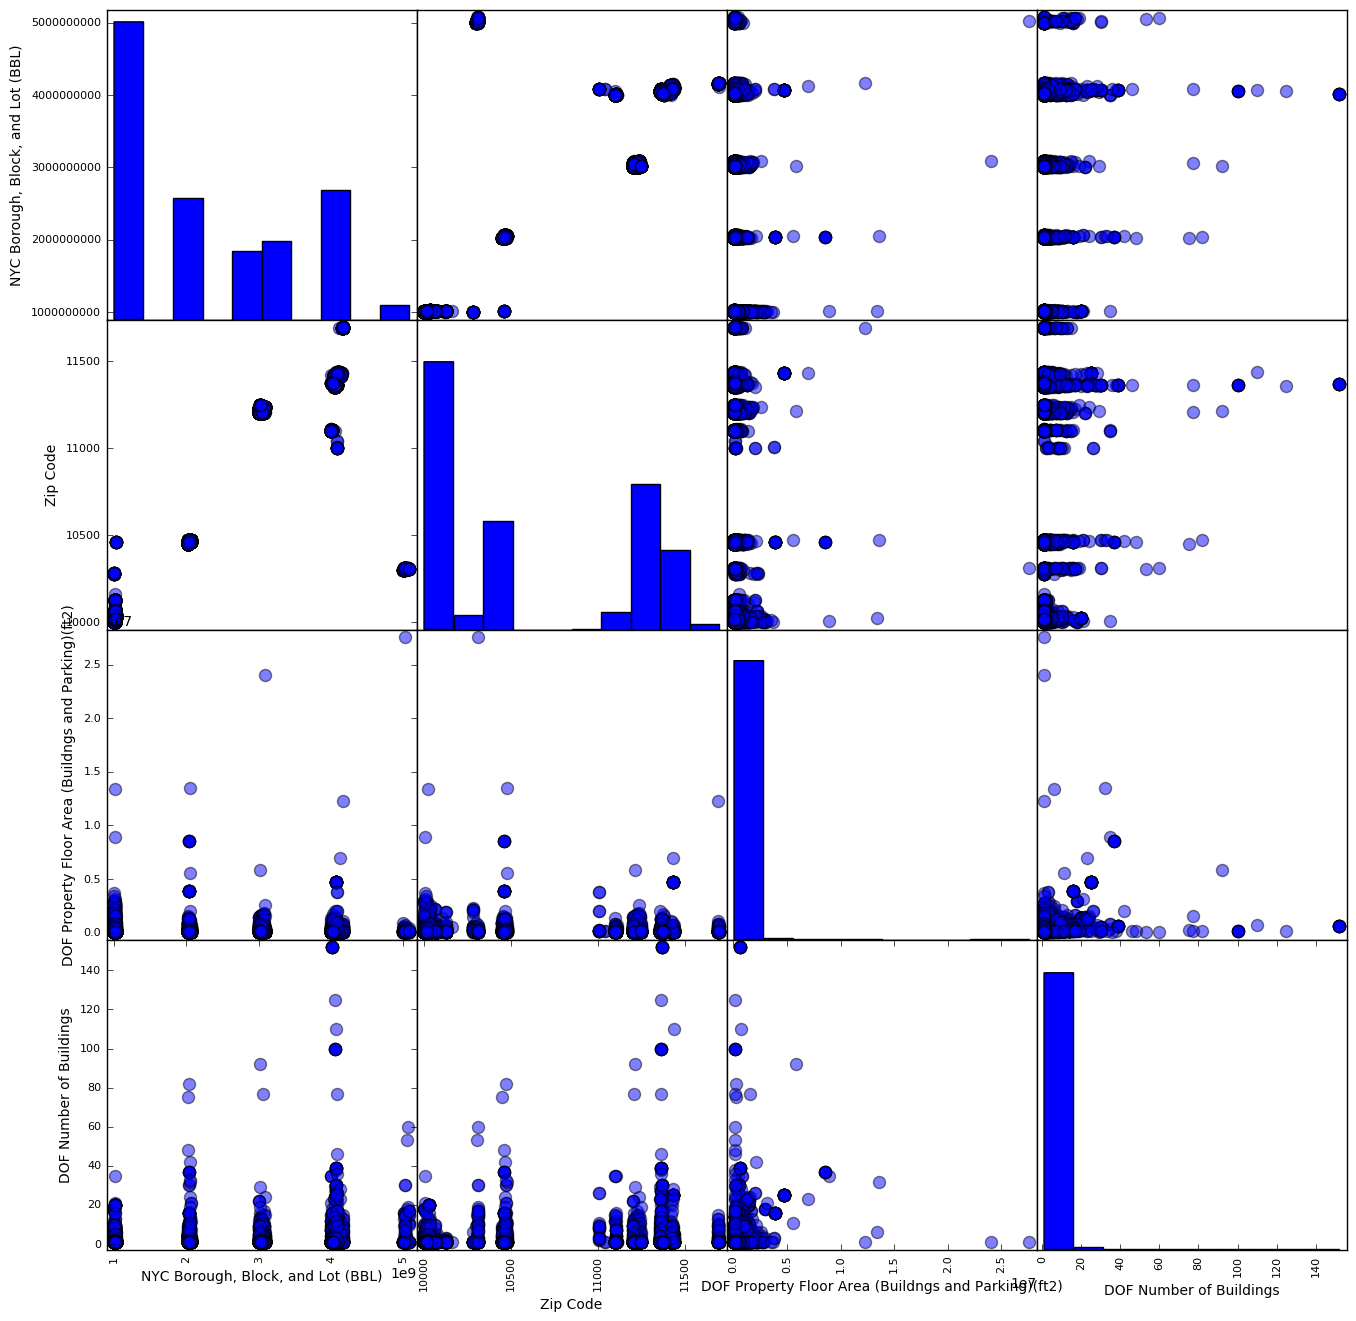

In [9]:
nrg_1 = nrg[['NYC Borough, Block, and Lot (BBL)','Zip Code','Reported Property Floor Area (Building(s)) (ft²)','DOF Property Floor Area (Buildngs and Parking)(ft2)','Site EUI(kBtu/ft2)','DOF Number of Buildings']]
scatter_matrix (nrg_1, s=300, figsize=(16, 16))

### Figure 1: scatter matrix of all numerical values in the files.  ( BUT ... pandas only plot only float! ) 

In [281]:
# This function would create a Boolean array to show whether there is a float
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False

In [283]:
# I get the error : "cannot convert the series to..." np.vectorize is used to pass the series as a whole
SiteE = (np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)'])) # create an array
SiteE

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [284]:
SiteE = (np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)']))
print ("invalid entries changed to NaN %d"%sum(SiteE))
nrg['Site EUI(kBtu/ft2)'][~SiteE] = float('NaN') # replace 'cannotconvert' by NaN 

invalid entries changed to NaN 15513


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### Pay great attention here: if you run above code the second time, NaN # will reach 16170, no matter which column of interest

In [287]:
#print (nrg['Site EUI(kBtu/ft2)'])

## MERGE THE DATASET

### Use the common column 'BBL' to join the information from the 2 datasets for each BBL value 

In [10]:
nrg_1 = nrg_1.rename(index=str, columns={'NYC Borough, Block, and Lot (BBL)':'BBL'})# create a common column by renaming
nrg_1.columns

Index([u'BBL', u'Zip Code',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Site EUI(kBtu/ft2)', u'DOF Number of Buildings'],
      dtype='object')

In [11]:
bsize_1 = bsize[['BBL','UnitsTotal']]

In [27]:
bblnrgdata= pd.merge(nrg_1, bsize_1, on='BBL') # merging two datasets on the common column
bblnrgdata.columns
#bblnrgdata

Index([                                                u'BBL',
                                                  u'Zip Code',
          u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
                                        u'Site EUI(kBtu/ft2)',
                                   u'DOF Number of Buildings',
                                                u'UnitsTotal'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8651408d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc81adacd50>]], dtype=object)

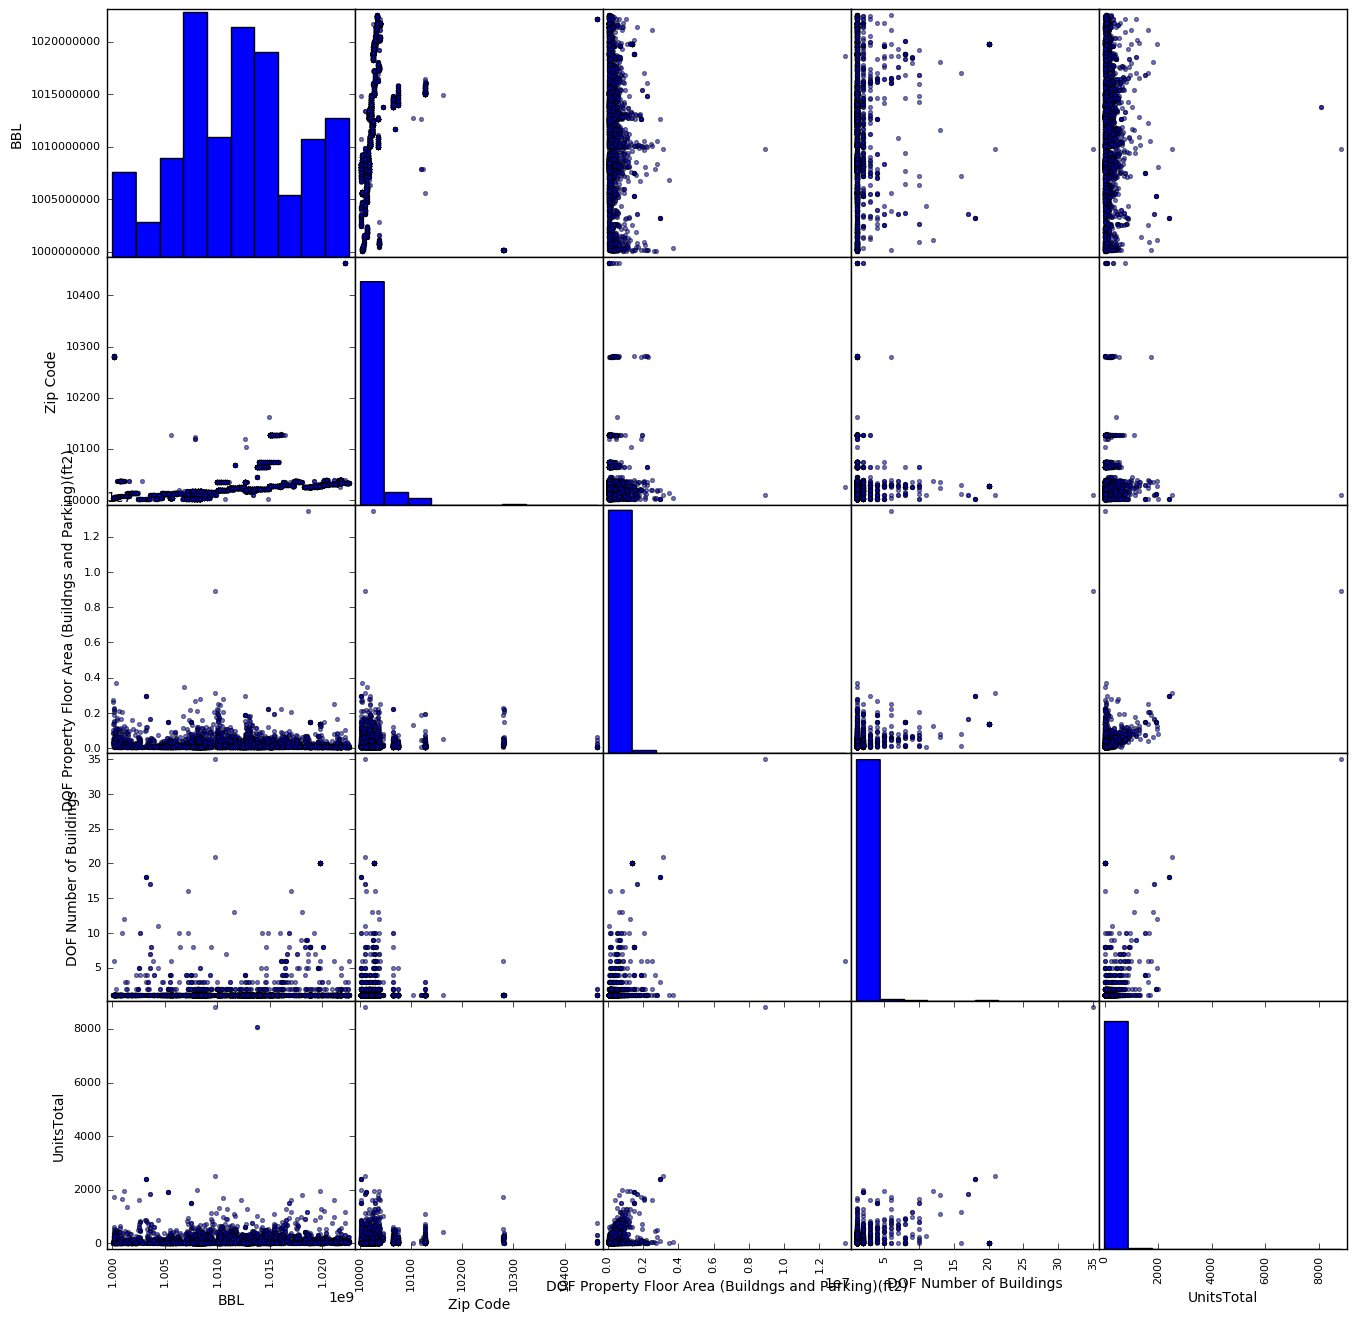

In [127]:
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16)) # shows more columns after merging

In [15]:
#bblnrgdata.convert_objects(convert_numeric = True).dtypes

In [42]:
#convert non-int of type 'str' to float
bblnrgdata['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')
bblnrgdata['BBL'] = pd.to_numeric(nrg['NYC Borough, Block, and Lot (BBL)'], errors='coerce')
bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'], 
                                                                     errors='coerce')

In [43]:
# calculate the energy consumption
bblnrgdata['Energy'] = bblnrgdata['Site EUI(kBtu/ft2)']*(bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'])

### The first scatter plot of Energy vs Units ( with really low unit numbers compared to its energy consumption)

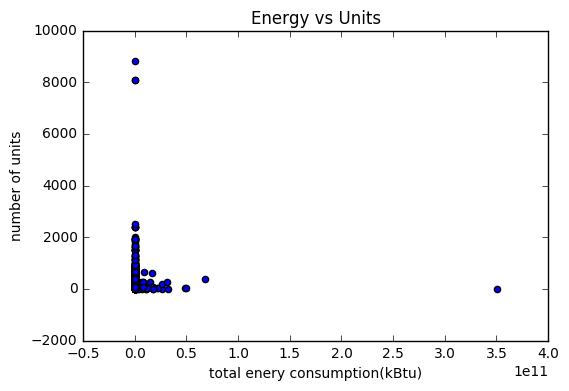

In [110]:
ax = bblnrgdata.plot.scatter(['Energy'],['UnitsTotal'])
ax.set_xlabel("total enery consumption(kBtu)")
ax.set_ylabel("number of units")
ax.set_title("Energy vs Units")

### The second plot of Energy vs Units (after adjusting the x, y-axis limitation )

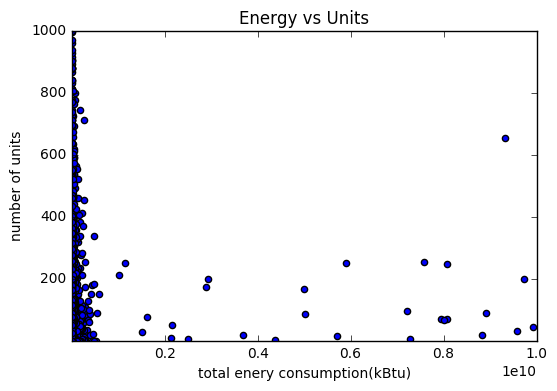

In [111]:
ax = bblnrgdata.plot.scatter(['Energy'],['UnitsTotal'])
ax.set_ylim(1,1000)
ax.set_xlim(1000,1e10)
ax.set_xlabel("total enery consumption(kBtu)")
ax.set_ylabel("number of units")
ax.set_title("Energy vs Units")

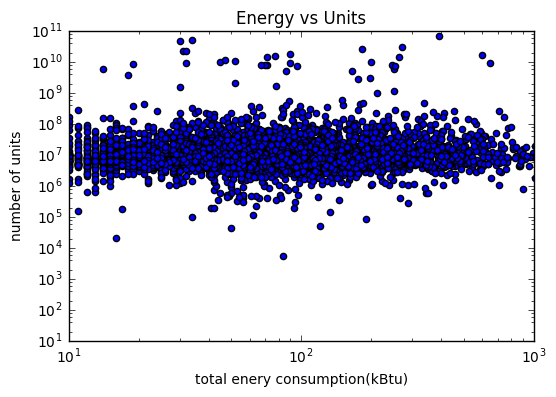

In [115]:
ax = bblnrgdata.plot.scatter('UnitsTotal', 'Energy',loglog = True)

ax.set_xlim(10,1e3)
ax.set_ylim(10,1e11)

ax.set_xlabel("total enery consumption(kBtu)")
ax.set_ylabel("number of units")
ax.set_title("Energy vs Units")

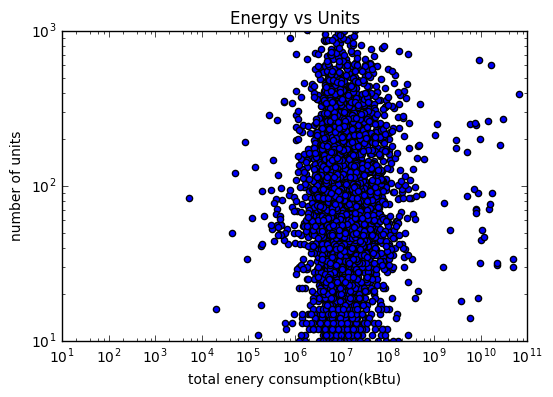

In [106]:
ax = bblnrgdata.plot.scatter('Energy', 'UnitsTotal',loglog = True)

ax.set_ylim(10,1e3)
ax.set_xlim(10,1e11)

ax.set_xlabel("total enery consumption(kBtu)")
ax.set_ylabel("number of units")
ax.set_title("Energy vs Units")

### still have to cut data

In [157]:
bblnrgdata_cut = bblnrgdata[(bblnrgdata['Energy'] > 1e6) & (bblnrgdata['Energy'] < 1e9) & (bblnrgdata['UnitsTotal'] >2) ]
#bblnrgdata_cut

### log plot

In [224]:
import statsmodels.api as sm

### Fit line 1

In [225]:
Y_1 = np.log10(bblnrgdata_cut.UnitsTotal)
X_1 = np.log10(bblnrgdata_cut.Energy)

In [229]:
X = sm.add_constant(X_1)
est_1= sm.OLS(Y_1, X, missing='drop').fit()
est_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     10.81
Date:                Wed, 19 Oct 2016   Prob (F-statistic):            0.00102
Time:                        21:43:06   Log-Likelihood:                -3512.0
No. Observations:                4726   AIC:                             7028.
Df Residuals:                    4724   BIC:                             7041.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.3956      0.128     10.889      0.000         1.144     1.647
Energy         0.0598      0.018      3.288      0.001         0.024     0.095
==============================================================================
Omnibus:                       79.096   Durbin-Watson:                   1.375
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.089
Skew:                          -0.248   Prob(JB):                     1.36e-21
Kurtosis:                       3.492   Cond. No.                         124.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

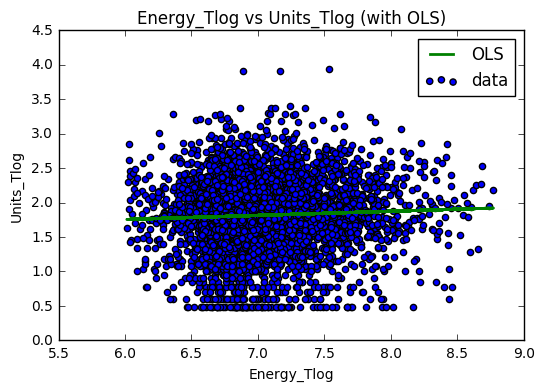

In [231]:
line_1 = est_1.predict(X) 
pl.scatter(X_1,Y_1, label="data" )
pl.plot(X_1,line_1, 'g', label="OLS", linewidth = 2)
pl.xlabel("Energy_Tlog")
pl.ylabel("Units_Tlog")
pl.title("Energy_Tlog vs Units_Tlog (with OLS)")

pl.legend(loc='best')

### Fit line 2

In [232]:
X_1 = np.log10(bblnrgdata_cut.UnitsTotal)
Y_1 = np.log10(bblnrgdata_cut.Energy)

In [233]:
X = sm.add_constant(X_1)
est_2= sm.OLS(Y_1, X, missing='drop').fit()
#est_2.summary()

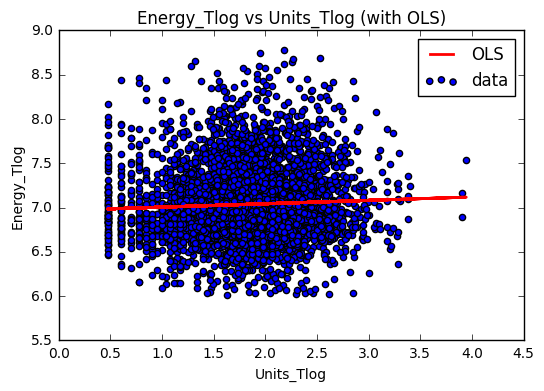

In [235]:
line_2 = est_2.predict(X) 
pl.scatter(X_1,Y_1, label="data" )
pl.plot(X_1,line_2, 'r', label="OLS", linewidth = 2)
pl.ylabel("Energy_Tlog")
pl.xlabel("Units_Tlog")
pl.title("Energy_Tlog vs Units_Tlog (with OLS)")

pl.legend(loc='best')

### evaluate chi square

In [252]:
#chisq = sum(exp-obs)**2/(obs)
chisq_1 = sum((X_1 - line_1 )**2 /(X_1))
chisq_1

1082.6312224297667

In [253]:
chisq_2 = sum((X_1 - line_2 )**2 /(X_1))
chisq_2

86818.045884559717

### fit a 2nd polynomial

In [255]:
import statsmodels.formula.api as smf

In [261]:
Z = Y_1**2
est_3 = smf.ols(formula='X_1 ~ Y_1 + Z', data = bblnrgdata_cut).fit()
est_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    X_1   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.417
Date:                Wed, 19 Oct 2016   Prob (F-statistic):            0.00447
Time:                        23:03:00   Log-Likelihood:                -3512.0
No. Observations:                4726   AIC:                             7030.
Df Residuals:                    4723   BIC:                             7049.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.6220      1.499      1.082      0.279        -1.316     4.560
Y_1           -0.0033      0.416     -0.008      0.994        -0.819     0.813
Z              0.0044      0.029      0.152      0.879        -0.052     0.061
==============================================================================
Omnibus:                       79.154   Durbin-Watson:                   1.375
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.175
Skew:                          -0.248   Prob(JB):                     1.31e-21
Kurtosis:                       3.492   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### compare two test models

In [262]:
LR = -2 * (est_1.llf - est_3.llf)
LR

0.023014509441054543

In [266]:
est_3.compare_lr_test(est_1)

(0.023014509441054543, 0.87941934714803571, 1.0)